In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Define the path to the covariates file
PHENOTYPE_PATH = "/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/Alzheimer-RV/data/phenotypes/36K_QC_filtered_final.csv"

# Load covariates data
XY = pd.read_csv(PHENOTYPE_PATH, sep=',', header=0)

# Filter based on race if not "ALL"
RACE = "ALL"  # Replace with actual race filter value if needed
if RACE != "ALL":
    XY = XY[XY['predicted_ancestry'] == RACE]

# Select columns for Y (Diagnosis) and X (covariates)
Y = XY[['Diagnosis']]
y = Y.values.flatten()  # Convert to 1D array

# Select covariates
X_covariates = XY[['Sex', 'Age', 'apoe_e4', 'apoe_e2', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
                   'Illumina_HiSeq_2000', 'Illumina_HiSeqX', 'Illumina_NovaSeq', 'Illumina', 'USUHS', 'NYGC', 
                   'MEDGENOME', 'Baylor', 'Broad', 'WashU', 'PRS_5']]

# Load and process gene matrix for TREM2 in coding cell type on chromosome 6
GENOTYPE_DIR = "/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/Alzheimer-RV/data/gene_matrices_maf/coding/chr6"
GENO_FILE = "TREM2_geno_imputed.csv"
GENOTYPE_PATH = f"{GENOTYPE_DIR}/{GENO_FILE}"

# Read and process gene matrix
df_gene = pd.read_csv(GENOTYPE_PATH)


scaler = StandardScaler()
X_gene = scaler.fit_transform(df_gene.values[:, 1:])  

# Combine gene matrix with covariates
X_combined = np.concatenate((X_covariates.values, X_gene), axis=1)

# Normalize combined input data
scaler_combined = StandardScaler()
X_scaled = scaler_combined.fit_transform(X_combined)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the logistic regression model
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs):
        super().__init__()
        self.linear = torch.nn.Linear(n_inputs, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

# Define model, loss function, and optimizer
# A loss function (also called a cost function or objective function) is a measure of how well the model's predictions match the actual data. 
#It quantifies the difference between the predicted output and the true output during the training process. 
#The goal of training is to minimize the loss function, thus improving the model's accuracy.

model = LogisticRegression(X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
#An optimizer is an algorithm that adjusts the model's parameters to minimize the loss function.
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_label = (y_pred_test >= 0.5).float()
    accuracy = (y_pred_label.eq(y_test_tensor).sum() / y_test.shape[0]).item()
    print(f'Accuracy: {accuracy:.4f}')

    # Print predictions for test samples
    correct = 0
    total = 0
    for i, x in enumerate(X_test_tensor):
        y_true = y_test_tensor[i].item()
        y_pred_prob = model(x).item()
        y_pred_label = 1 if y_pred_prob >= 0.5 else 0
        print(f'Sample {i+1}: True Label={y_true}, Predicted Label={y_pred_label} (Probability={y_pred_prob:.4f})')
        
        # Check accuracy
        total += 1
        if y_pred_label == y_true:
            correct += 1

    accuracy = correct / total
    print(f'\nAccuracy: {accuracy:.4f}')

# Calculate AUC
y_pred_test_prob = model(X_test_tensor).detach().numpy()
y_test_np = y_test_tensor.numpy()
auc = roc_auc_score(y_test_np, y_pred_test_prob)
print(f'AUC: {auc:.4f}')


Epoch [100/1000], Loss: 0.6426
Epoch [200/1000], Loss: 0.6132
Epoch [300/1000], Loss: 0.5969
Epoch [400/1000], Loss: 0.5869
Epoch [500/1000], Loss: 0.5804
Epoch [600/1000], Loss: 0.5760
Epoch [700/1000], Loss: 0.5728
Epoch [800/1000], Loss: 0.5705
Epoch [900/1000], Loss: 0.5688
Epoch [1000/1000], Loss: 0.5675
Accuracy: 0.7065
Sample 1: True Label=1.0, Predicted Label=1 (Probability=0.5223)
Sample 2: True Label=0.0, Predicted Label=0 (Probability=0.2158)
Sample 3: True Label=1.0, Predicted Label=0 (Probability=0.4667)
Sample 4: True Label=0.0, Predicted Label=0 (Probability=0.2568)
Sample 5: True Label=0.0, Predicted Label=0 (Probability=0.2973)
Sample 6: True Label=1.0, Predicted Label=0 (Probability=0.2701)
Sample 7: True Label=0.0, Predicted Label=0 (Probability=0.2741)
Sample 8: True Label=0.0, Predicted Label=0 (Probability=0.0745)
Sample 9: True Label=0.0, Predicted Label=0 (Probability=0.2129)
Sample 10: True Label=0.0, Predicted Label=0 (Probability=0.3254)
Sample 11: True Label

Sample 522: True Label=0.0, Predicted Label=0 (Probability=0.1853)
Sample 523: True Label=0.0, Predicted Label=0 (Probability=0.2268)
Sample 524: True Label=0.0, Predicted Label=0 (Probability=0.3481)
Sample 525: True Label=0.0, Predicted Label=0 (Probability=0.1784)
Sample 526: True Label=0.0, Predicted Label=1 (Probability=0.5052)
Sample 527: True Label=0.0, Predicted Label=1 (Probability=0.5891)
Sample 528: True Label=0.0, Predicted Label=1 (Probability=0.5007)
Sample 529: True Label=1.0, Predicted Label=0 (Probability=0.2691)
Sample 530: True Label=0.0, Predicted Label=0 (Probability=0.4588)
Sample 531: True Label=0.0, Predicted Label=0 (Probability=0.3425)
Sample 532: True Label=0.0, Predicted Label=0 (Probability=0.3821)
Sample 533: True Label=0.0, Predicted Label=0 (Probability=0.4449)
Sample 534: True Label=1.0, Predicted Label=1 (Probability=0.5936)
Sample 535: True Label=0.0, Predicted Label=1 (Probability=0.5176)
Sample 536: True Label=1.0, Predicted Label=1 (Probability=0.7

Sample 1235: True Label=1.0, Predicted Label=0 (Probability=0.4443)
Sample 1236: True Label=1.0, Predicted Label=0 (Probability=0.1856)
Sample 1237: True Label=0.0, Predicted Label=1 (Probability=0.6420)
Sample 1238: True Label=1.0, Predicted Label=1 (Probability=0.5290)
Sample 1239: True Label=0.0, Predicted Label=0 (Probability=0.4521)
Sample 1240: True Label=1.0, Predicted Label=1 (Probability=0.9143)
Sample 1241: True Label=0.0, Predicted Label=0 (Probability=0.2108)
Sample 1242: True Label=0.0, Predicted Label=1 (Probability=0.6810)
Sample 1243: True Label=1.0, Predicted Label=0 (Probability=0.2922)
Sample 1244: True Label=0.0, Predicted Label=1 (Probability=0.5216)
Sample 1245: True Label=0.0, Predicted Label=0 (Probability=0.0664)
Sample 1246: True Label=1.0, Predicted Label=1 (Probability=0.5004)
Sample 1247: True Label=0.0, Predicted Label=0 (Probability=0.3144)
Sample 1248: True Label=0.0, Predicted Label=0 (Probability=0.4192)
Sample 1249: True Label=0.0, Predicted Label=0 (

Sample 1962: True Label=1.0, Predicted Label=1 (Probability=0.6600)
Sample 1963: True Label=0.0, Predicted Label=0 (Probability=0.2657)
Sample 1964: True Label=0.0, Predicted Label=0 (Probability=0.0851)
Sample 1965: True Label=0.0, Predicted Label=0 (Probability=0.2942)
Sample 1966: True Label=0.0, Predicted Label=0 (Probability=0.4635)
Sample 1967: True Label=0.0, Predicted Label=0 (Probability=0.4991)
Sample 1968: True Label=0.0, Predicted Label=0 (Probability=0.3145)
Sample 1969: True Label=0.0, Predicted Label=1 (Probability=0.5771)
Sample 1970: True Label=0.0, Predicted Label=1 (Probability=0.6238)
Sample 1971: True Label=1.0, Predicted Label=0 (Probability=0.4516)
Sample 1972: True Label=0.0, Predicted Label=0 (Probability=0.3294)
Sample 1973: True Label=0.0, Predicted Label=0 (Probability=0.4384)
Sample 1974: True Label=0.0, Predicted Label=1 (Probability=0.6695)
Sample 1975: True Label=1.0, Predicted Label=1 (Probability=0.5473)
Sample 1976: True Label=0.0, Predicted Label=0 (

Sample 2675: True Label=1.0, Predicted Label=1 (Probability=0.5796)
Sample 2676: True Label=0.0, Predicted Label=1 (Probability=0.9584)
Sample 2677: True Label=0.0, Predicted Label=0 (Probability=0.3399)
Sample 2678: True Label=0.0, Predicted Label=0 (Probability=0.3426)
Sample 2679: True Label=0.0, Predicted Label=1 (Probability=0.5198)
Sample 2680: True Label=1.0, Predicted Label=0 (Probability=0.1633)
Sample 2681: True Label=1.0, Predicted Label=0 (Probability=0.1810)
Sample 2682: True Label=1.0, Predicted Label=1 (Probability=0.7891)
Sample 2683: True Label=0.0, Predicted Label=0 (Probability=0.2002)
Sample 2684: True Label=0.0, Predicted Label=0 (Probability=0.2349)
Sample 2685: True Label=0.0, Predicted Label=0 (Probability=0.4293)
Sample 2686: True Label=1.0, Predicted Label=1 (Probability=0.5443)
Sample 2687: True Label=0.0, Predicted Label=0 (Probability=0.0700)
Sample 2688: True Label=0.0, Predicted Label=0 (Probability=0.1697)
Sample 2689: True Label=1.0, Predicted Label=1 (

Sample 3398: True Label=0.0, Predicted Label=0 (Probability=0.3016)
Sample 3399: True Label=0.0, Predicted Label=1 (Probability=0.5333)
Sample 3400: True Label=0.0, Predicted Label=0 (Probability=0.2392)
Sample 3401: True Label=0.0, Predicted Label=0 (Probability=0.3224)
Sample 3402: True Label=1.0, Predicted Label=1 (Probability=0.7059)
Sample 3403: True Label=1.0, Predicted Label=0 (Probability=0.4739)
Sample 3404: True Label=0.0, Predicted Label=0 (Probability=0.4254)
Sample 3405: True Label=0.0, Predicted Label=0 (Probability=0.1099)
Sample 3406: True Label=1.0, Predicted Label=0 (Probability=0.3817)
Sample 3407: True Label=1.0, Predicted Label=1 (Probability=0.8264)
Sample 3408: True Label=1.0, Predicted Label=1 (Probability=0.6644)
Sample 3409: True Label=0.0, Predicted Label=1 (Probability=0.5588)
Sample 3410: True Label=0.0, Predicted Label=1 (Probability=0.6611)
Sample 3411: True Label=0.0, Predicted Label=0 (Probability=0.2829)
Sample 3412: True Label=0.0, Predicted Label=0 (

Sample 4085: True Label=0.0, Predicted Label=0 (Probability=0.2486)
Sample 4086: True Label=0.0, Predicted Label=1 (Probability=0.5088)
Sample 4087: True Label=0.0, Predicted Label=0 (Probability=0.2101)
Sample 4088: True Label=1.0, Predicted Label=1 (Probability=0.5313)
Sample 4089: True Label=1.0, Predicted Label=0 (Probability=0.4514)
Sample 4090: True Label=0.0, Predicted Label=0 (Probability=0.4319)
Sample 4091: True Label=0.0, Predicted Label=0 (Probability=0.1986)
Sample 4092: True Label=1.0, Predicted Label=0 (Probability=0.1814)
Sample 4093: True Label=1.0, Predicted Label=0 (Probability=0.4605)
Sample 4094: True Label=0.0, Predicted Label=0 (Probability=0.1867)
Sample 4095: True Label=0.0, Predicted Label=0 (Probability=0.2393)
Sample 4096: True Label=1.0, Predicted Label=1 (Probability=0.8386)
Sample 4097: True Label=1.0, Predicted Label=0 (Probability=0.2921)
Sample 4098: True Label=0.0, Predicted Label=1 (Probability=0.6117)
Sample 4099: True Label=1.0, Predicted Label=0 (

Epoch [100/1000], Loss: 0.6416, AUC: 0.6940
Epoch [200/1000], Loss: 0.6135, AUC: 0.7140
Epoch [300/1000], Loss: 0.5978, AUC: 0.7196
Epoch [400/1000], Loss: 0.5879, AUC: 0.7221
Epoch [500/1000], Loss: 0.5812, AUC: 0.7236
Epoch [600/1000], Loss: 0.5766, AUC: 0.7245
Epoch [700/1000], Loss: 0.5732, AUC: 0.7251
Epoch [800/1000], Loss: 0.5708, AUC: 0.7256
Epoch [900/1000], Loss: 0.5691, AUC: 0.7259
Epoch [1000/1000], Loss: 0.5679, AUC: 0.7263


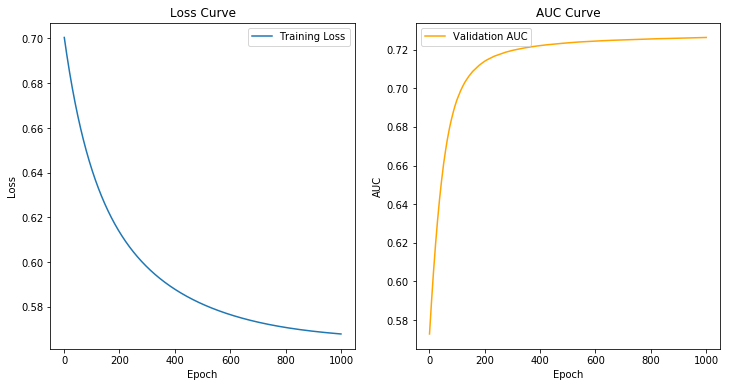

Accuracy: 0.7063
Sample 1: True Label=1.0, Predicted Label=1 (Probability=0.5028)
Sample 2: True Label=0.0, Predicted Label=0 (Probability=0.2397)
Sample 3: True Label=1.0, Predicted Label=0 (Probability=0.4540)
Sample 4: True Label=0.0, Predicted Label=0 (Probability=0.2673)
Sample 5: True Label=0.0, Predicted Label=0 (Probability=0.2908)
Sample 6: True Label=1.0, Predicted Label=0 (Probability=0.2631)
Sample 7: True Label=0.0, Predicted Label=0 (Probability=0.2865)
Sample 8: True Label=0.0, Predicted Label=0 (Probability=0.0696)
Sample 9: True Label=0.0, Predicted Label=0 (Probability=0.2107)
Sample 10: True Label=0.0, Predicted Label=0 (Probability=0.3294)
Sample 11: True Label=0.0, Predicted Label=0 (Probability=0.1008)
Sample 12: True Label=0.0, Predicted Label=0 (Probability=0.2979)
Sample 13: True Label=1.0, Predicted Label=0 (Probability=0.4258)
Sample 14: True Label=1.0, Predicted Label=0 (Probability=0.3911)
Sample 15: True Label=1.0, Predicted Label=1 (Probability=0.6431)
Sa

Sample 281: True Label=1.0, Predicted Label=1 (Probability=0.6214)
Sample 282: True Label=0.0, Predicted Label=0 (Probability=0.0945)
Sample 283: True Label=0.0, Predicted Label=0 (Probability=0.2331)
Sample 284: True Label=1.0, Predicted Label=1 (Probability=0.7004)
Sample 285: True Label=0.0, Predicted Label=0 (Probability=0.4054)
Sample 286: True Label=1.0, Predicted Label=1 (Probability=0.7909)
Sample 287: True Label=0.0, Predicted Label=0 (Probability=0.3732)
Sample 288: True Label=1.0, Predicted Label=0 (Probability=0.3004)
Sample 289: True Label=1.0, Predicted Label=1 (Probability=0.6359)
Sample 290: True Label=0.0, Predicted Label=0 (Probability=0.1298)
Sample 291: True Label=0.0, Predicted Label=0 (Probability=0.3360)
Sample 292: True Label=0.0, Predicted Label=0 (Probability=0.2091)
Sample 293: True Label=0.0, Predicted Label=0 (Probability=0.4726)
Sample 294: True Label=0.0, Predicted Label=0 (Probability=0.4806)
Sample 295: True Label=1.0, Predicted Label=0 (Probability=0.1

Sample 917: True Label=1.0, Predicted Label=1 (Probability=0.8871)
Sample 918: True Label=0.0, Predicted Label=0 (Probability=0.0935)
Sample 919: True Label=0.0, Predicted Label=0 (Probability=0.2518)
Sample 920: True Label=0.0, Predicted Label=0 (Probability=0.3968)
Sample 921: True Label=0.0, Predicted Label=0 (Probability=0.4781)
Sample 922: True Label=0.0, Predicted Label=0 (Probability=0.3028)
Sample 923: True Label=1.0, Predicted Label=0 (Probability=0.2955)
Sample 924: True Label=0.0, Predicted Label=1 (Probability=0.5711)
Sample 925: True Label=1.0, Predicted Label=1 (Probability=0.5675)
Sample 926: True Label=0.0, Predicted Label=0 (Probability=0.2887)
Sample 927: True Label=1.0, Predicted Label=0 (Probability=0.2173)
Sample 928: True Label=0.0, Predicted Label=0 (Probability=0.4429)
Sample 929: True Label=1.0, Predicted Label=0 (Probability=0.4775)
Sample 930: True Label=0.0, Predicted Label=0 (Probability=0.0790)
Sample 931: True Label=0.0, Predicted Label=0 (Probability=0.4

Sample 1544: True Label=0.0, Predicted Label=0 (Probability=0.4395)
Sample 1545: True Label=1.0, Predicted Label=0 (Probability=0.2491)
Sample 1546: True Label=0.0, Predicted Label=0 (Probability=0.4730)
Sample 1547: True Label=0.0, Predicted Label=0 (Probability=0.2198)
Sample 1548: True Label=0.0, Predicted Label=1 (Probability=0.5415)
Sample 1549: True Label=0.0, Predicted Label=0 (Probability=0.0864)
Sample 1550: True Label=1.0, Predicted Label=0 (Probability=0.3116)
Sample 1551: True Label=0.0, Predicted Label=0 (Probability=0.4836)
Sample 1552: True Label=0.0, Predicted Label=0 (Probability=0.4443)
Sample 1553: True Label=0.0, Predicted Label=0 (Probability=0.2689)
Sample 1554: True Label=1.0, Predicted Label=0 (Probability=0.2891)
Sample 1555: True Label=0.0, Predicted Label=0 (Probability=0.0873)
Sample 1556: True Label=0.0, Predicted Label=0 (Probability=0.1942)
Sample 1557: True Label=1.0, Predicted Label=0 (Probability=0.4522)
Sample 1558: True Label=1.0, Predicted Label=0 (

Sample 2080: True Label=0.0, Predicted Label=0 (Probability=0.1008)
Sample 2081: True Label=0.0, Predicted Label=1 (Probability=0.6173)
Sample 2082: True Label=1.0, Predicted Label=0 (Probability=0.2475)
Sample 2083: True Label=0.0, Predicted Label=0 (Probability=0.3772)
Sample 2084: True Label=1.0, Predicted Label=0 (Probability=0.4379)
Sample 2085: True Label=1.0, Predicted Label=1 (Probability=0.7522)
Sample 2086: True Label=1.0, Predicted Label=1 (Probability=0.9084)
Sample 2087: True Label=1.0, Predicted Label=1 (Probability=0.5388)
Sample 2088: True Label=0.0, Predicted Label=0 (Probability=0.0949)
Sample 2089: True Label=0.0, Predicted Label=0 (Probability=0.2298)
Sample 2090: True Label=0.0, Predicted Label=0 (Probability=0.2308)
Sample 2091: True Label=0.0, Predicted Label=0 (Probability=0.2319)
Sample 2092: True Label=0.0, Predicted Label=0 (Probability=0.1769)
Sample 2093: True Label=0.0, Predicted Label=0 (Probability=0.0675)
Sample 2094: True Label=1.0, Predicted Label=0 (

Sample 2681: True Label=1.0, Predicted Label=0 (Probability=0.1872)
Sample 2682: True Label=1.0, Predicted Label=1 (Probability=0.7915)
Sample 2683: True Label=0.0, Predicted Label=0 (Probability=0.2130)
Sample 2684: True Label=0.0, Predicted Label=0 (Probability=0.2357)
Sample 2685: True Label=0.0, Predicted Label=0 (Probability=0.4216)
Sample 2686: True Label=1.0, Predicted Label=1 (Probability=0.5703)
Sample 2687: True Label=0.0, Predicted Label=0 (Probability=0.0860)
Sample 2688: True Label=0.0, Predicted Label=0 (Probability=0.1800)
Sample 2689: True Label=1.0, Predicted Label=1 (Probability=0.6281)
Sample 2690: True Label=0.0, Predicted Label=0 (Probability=0.3523)
Sample 2691: True Label=0.0, Predicted Label=0 (Probability=0.2214)
Sample 2692: True Label=1.0, Predicted Label=0 (Probability=0.4422)
Sample 2693: True Label=0.0, Predicted Label=0 (Probability=0.1978)
Sample 2694: True Label=0.0, Predicted Label=1 (Probability=0.8888)
Sample 2695: True Label=1.0, Predicted Label=1 (

Sample 3292: True Label=0.0, Predicted Label=0 (Probability=0.2451)
Sample 3293: True Label=1.0, Predicted Label=1 (Probability=0.5311)
Sample 3294: True Label=0.0, Predicted Label=0 (Probability=0.2213)
Sample 3295: True Label=1.0, Predicted Label=0 (Probability=0.4984)
Sample 3296: True Label=0.0, Predicted Label=1 (Probability=0.5661)
Sample 3297: True Label=0.0, Predicted Label=0 (Probability=0.2441)
Sample 3298: True Label=0.0, Predicted Label=0 (Probability=0.2985)
Sample 3299: True Label=0.0, Predicted Label=0 (Probability=0.1296)
Sample 3300: True Label=1.0, Predicted Label=0 (Probability=0.4177)
Sample 3301: True Label=0.0, Predicted Label=0 (Probability=0.3037)
Sample 3302: True Label=1.0, Predicted Label=0 (Probability=0.2810)
Sample 3303: True Label=0.0, Predicted Label=1 (Probability=0.7027)
Sample 3304: True Label=0.0, Predicted Label=0 (Probability=0.2362)
Sample 3305: True Label=1.0, Predicted Label=1 (Probability=0.7379)
Sample 3306: True Label=1.0, Predicted Label=1 (

Sample 3904: True Label=0.0, Predicted Label=0 (Probability=0.4438)
Sample 3905: True Label=0.0, Predicted Label=0 (Probability=0.3033)
Sample 3906: True Label=1.0, Predicted Label=0 (Probability=0.1773)
Sample 3907: True Label=1.0, Predicted Label=1 (Probability=0.6261)
Sample 3908: True Label=1.0, Predicted Label=0 (Probability=0.1559)
Sample 3909: True Label=1.0, Predicted Label=1 (Probability=0.8166)
Sample 3910: True Label=0.0, Predicted Label=0 (Probability=0.0875)
Sample 3911: True Label=0.0, Predicted Label=0 (Probability=0.3891)
Sample 3912: True Label=1.0, Predicted Label=1 (Probability=0.7556)
Sample 3913: True Label=0.0, Predicted Label=0 (Probability=0.2725)
Sample 3914: True Label=0.0, Predicted Label=0 (Probability=0.0838)
Sample 3915: True Label=0.0, Predicted Label=1 (Probability=0.7333)
Sample 3916: True Label=0.0, Predicted Label=0 (Probability=0.2699)
Sample 3917: True Label=1.0, Predicted Label=0 (Probability=0.3107)
Sample 3918: True Label=0.0, Predicted Label=0 (

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Define the path to the covariates file
PHENOTYPE_PATH = "/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/Alzheimer-RV/data/phenotypes/36K_QC_filtered_final.csv"

# Load covariates data
XY = pd.read_csv(PHENOTYPE_PATH, sep=',', header=0)

# Filter based on race if not "ALL"
RACE = "ALL"  # Replace with actual race filter value if needed
if RACE != "ALL":
    XY = XY[XY['predicted_ancestry'] == RACE]

# Select columns for Y (Diagnosis) and X (covariates)
Y = XY[['Diagnosis']]
y = Y.values.flatten()  # Convert to 1D array

# Select covariates
X_covariates = XY[['Sex', 'Age', 'apoe_e4', 'apoe_e2', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
                   'Illumina_HiSeq_2000', 'Illumina_HiSeqX', 'Illumina_NovaSeq', 'Illumina', 'USUHS', 'NYGC', 
                   'MEDGENOME', 'Baylor', 'Broad', 'WashU', 'PRS_5']]

# Load and process gene matrix for TREM2 in coding cell type on chromosome 6
GENOTYPE_DIR = "/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/Alzheimer-RV/data/gene_matrices_maf/coding/chr6"
GENO_FILE = "TREM2_geno_imputed.csv"
GENOTYPE_PATH = f"{GENOTYPE_DIR}/{GENO_FILE}"

# Read and process gene matrix
df_gene = pd.read_csv(GENOTYPE_PATH)

scaler = StandardScaler()
X_gene = scaler.fit_transform(df_gene.values[:, 1:])  

# Combine gene matrix with covariates
X_combined = np.concatenate((X_covariates.values, X_gene), axis=1)

# Normalize combined input data
scaler_combined = StandardScaler()
X_scaled = scaler_combined.fit_transform(X_combined)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the logistic regression model
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs):
        super().__init__()
        self.linear = torch.nn.Linear(n_inputs, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

# Define model, loss function, and optimizer
model = LogisticRegression(X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Store the loss and AUC values
loss_values = []
auc_values = []

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    # Calculate AUC for the validation set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        y_pred_test_prob = y_pred_test.detach().numpy()
        y_test_np = y_test_tensor.numpy()
        auc = roc_auc_score(y_test_np, y_pred_test_prob)
        auc_values.append(auc)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, AUC: {auc:.4f}')

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot the AUC curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), auc_values, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Curve')
plt.legend()

# Save the plots
plt.savefig("loss_and_auc_curve.png")
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_label = (y_pred_test >= 0.5).float()
    accuracy = (y_pred_label.eq(y_test_tensor).sum() / y_test.shape[0]).item()
    print(f'Accuracy: {accuracy:.4f}')

    # Print predictions for test samples
    correct = 0
    total = 0
    for i, x in enumerate(X_test_tensor):
        y_true = y_test_tensor[i].item()
        y_pred_prob = model(x).item()
        y_pred_label = 1 if y_pred_prob >= 0.5 else 0
        print(f'Sample {i+1}: True Label={y_true}, Predicted Label={y_pred_label} (Probability={y_pred_prob:.4f})')
        
        # Check accuracy
        total += 1
        if y_pred_label == y_true:
            correct += 1

    accuracy = correct / total
    print(f'\nAccuracy: {accuracy:.4f}')

# Calculate AUC for the final model
y_pred_test_prob = model(X_test_tensor).detach().numpy()
y_test_np = y_test_tensor.numpy()
auc = roc_auc_score(y_test_np, y_pred_test_prob)
print(f'AUC: {auc:.4f}')
